In [11]:
%matplotlib inline

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

from matplotlib import animation, rc
from IPython.display import HTML, Image, clear_output

In [13]:
rc('animation', html='html5')

# Résolution numérique d'EDP

Ici, on s'intéresse à la résolution de l'*équation de la chaleur*
$$
\begin{aligned}
\frac{\partial u}{\partial t} &= D\frac{\partial^2 u}{\partial x^2} \\
u(x,0) &= 25 + 10\exp\left(-\frac{(x-a)^2}{\sigma^2}\right) \quad &\text{(Conditions initiales)} \\
\frac{\partial u}{\partial x}(0,t) &= \frac{\partial u}{\partial x}u(L,t) = 0\quad &\text{(Conditions aux limites de Neumann)}
\end{aligned}
$$
sur un domaine $\Omega = [0,L]\times[0,T]$, avec $0 < a < L$. 

Pour cela, on va discrétiser $\Omega$ sous la forme $(x_j,t_n)=(j\Delta x,n\Delta t)_{j,n}$, $0\le j< J$ et $0\le n< N$.

In [37]:
T = 180 # temps de la simulation numérique
L = 0.25

Nmax = 500
time_s = np.linspace(0,T,Nmax)
dt = T/Nmax

Jmax = 200
X_s = np.linspace(0,L,Jmax)
dx = 1/Jmax

spacetime = np.meshgrid(X_s, time_s)

On pose, pour tout $(j,n)\in [\![0,J-1]\!]\times[\![0,N-1]\!]$, $u_j^n := u(j\Delta x,n\Delta t)$. Alors, en discrétisant les dérivées,
$$
\frac{\partial u}{\partial t} \approx \frac{u_j^{n+1}-u_j^n}{\Delta t}\quad \text{et}\quad \frac{\partial^2u}{\partial x^2}\approx \frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1} + u_{j+1}^n - 2u_j^n + u_{j-1}^n}{2(\Delta x)^2}.
$$

On pose $r:=\frac{D\Delta t}{(\Delta x)^2}$ ; alors on est amené au système d'équations
$$
-ru_{j+1}^{n+1}+(1+2r)u_j^{n+1} - ru_{j-1}^{n+1} = (1-2r)u_j^n + r\left(u_{j+1}^n+u_{j-1}^n\right)\quad \forall (j,n)\in[\![0,J-1]\!]\times[\![0,N-1]\!].
$$

Le problème ici c'est que $u_{-1}^n$ et $u_J^n$ ne sont pas définis. Avec les conditions aux limites
$$
\partial_xu(0,t) = \partial_xu(1,t) = 0
$$
on a
$$
u_{-1}^n = u_0^n \quad\text{et}\quad u_{J}^n = u_{J-1}^n\quad\forall n
$$

ce qui conduit à
$$
\begin{aligned}
-ru_1^{n+1}+ (1+r)u_0^{n+1} &= (1-r)u_0^n + ru_1^n \\
(1+r)u_{J-1}^{n+1}-ru_{J-2}^{n+1} &= (1-r)u_{J-1}^n + ru_{J-2}^n
\end{aligned}
$$

On pose $\mathbf U^n = \begin{bmatrix} u_0^{n} \\ \vdots \\ u_{J-1}^n \end{bmatrix}$ le vecteur d'état du système à l'instant $t_n = n\Delta t $ et les matrices
$$\mathbf A 
= \begin{bmatrix}
1+r   & -r  &        &         &       \\
-r & 1+2r   & -r      &        &  \\
   & \ddots & \ddots & \ddots &  \\
   &        & -r      & 1+2r   & -r \\
   &        &        & -r      &  1+r      
\end{bmatrix}
$$
et
$$\mathbf B 
= \begin{bmatrix}
1-r   & r  &        &         &       \\
r & 1-2r   & r      &        &  \\
   & \ddots & \ddots & \ddots &  \\
   &        & r      & 1-2r   & r \\
   &        &        & r      &  1-r      
\end{bmatrix}.
$$


On a donc la relation de passage d'un état au suivant :
$$
\mathbf A\mathbf U^{n+1} = \mathbf B\mathbf U^n,
$$
mais $\mathbf A$ étant inversible,
$$
\mathbf U^{n+1} = \mathbf A^{-1}\mathbf B\mathbf U^n
$$

La fonction `process_matrix` définit les matrices $\mathbf A$ et $\mathbf B$.

In [44]:
def process_matrix(J):
    r = 22.9e-5*dt/(dx*dx)
    A = np.zeros((J,J))
    B = np.zeros((J,J))
    for j in range(0,J):
        if j == 0 or j== J-1:
            A[j][j] = 1 + r
            B[j][j] = 1 - r
        else:
            A[j][j] = 1 + 2* r
            B[j][j] = 1 - 2*r
        if j > 0:
            A[j][j-1] = -r
            B[j][j-1] = r
        if j < J-1:
            A[j][j+1] = -r
            B[j][j+1] = r
    return A,B

On définit les matrices $\mathbf A$ et $\mathbf B$, ainsi que $\mathbf C = \mathbf A^{-1}\mathbf B$ de sorte que
$$
\mathbf U^{n+1} = \mathbf C\mathbf U^n.
$$

In [45]:
A,B = process_matrix(Jmax)
C = np.matmul(np.linalg.inv(A),B)

La fonction suivante applique la méthode de Crank-Nicolson, trace les graphes des solutions :

In [55]:
def solvaro(U0, animate = False):
    # Condition initiale
    A,B = process_matrix(Jmax)
    C = np.matmul(np.linalg.inv(A),B)
    
    sol = [U0]
    for t in time_s:
        sol.append(np.matmul(sol[-1],C))
    
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.grid(True)
    ax.set_xlabel(r"Position $x$ ($m$)")
    ax.set_ylabel(r"Température $u(x,t)$ ($°C$)")
    
    ax.set_xlim((0,L))
    ymin, ymax = U0.min(), U0.max()
    ax.set_ylim((ymin,ymax))
    
    if animate:
        line, = ax.plot([], [], lw = 2)
        time_text = ax.text(0.4,1.1, '',transform=ax.transAxes)

        time_window = T
        fps = 30
        dt = 1000/fps
        frames = len(time_s)

        def init():
            line.set_data([],[])
            time_text.set_text(r'$t=0$ $\mathrm{s}$')
            return line,

        def animate(i):
            ti = time_window*i/frames
            line.set_data(X_s,sol[i])
            time_text.set_text(r'$t={:.1e}$'.format(ti)+r' $\mathrm{s}$')
            return line,

        anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                   frames=frames, interval=dt, blit=True)
        return anim
    else:
        for n in [0,10,50,100,250,450]:
            ax.plot(X_s,sol[n])

La condition initiale $u(x,0)$ se discrétise en
$$
\mathbf U^0 = {\left(25+10\exp\left(-\frac{(x_j-x_0)^2}{\sigma^2}\right) \right)}_{j\in[\![0,N-1]\!]}
$$

In [62]:
sigma = 0.3
x0 = 0.12

U0 = 25+10*np.exp(-25*(X_s-x0)**2/sigma**2)

On peut donc appliquer l'algorithme:

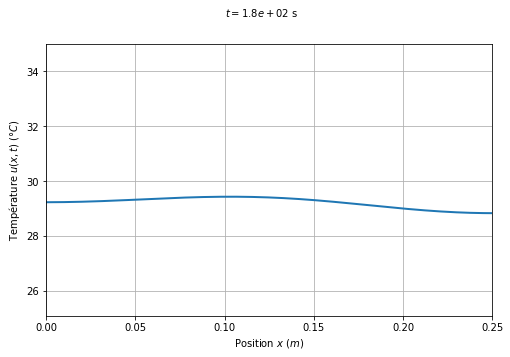

In [63]:
solvaro(U0, True)

Une autre simulation, avec $x_0=0$:

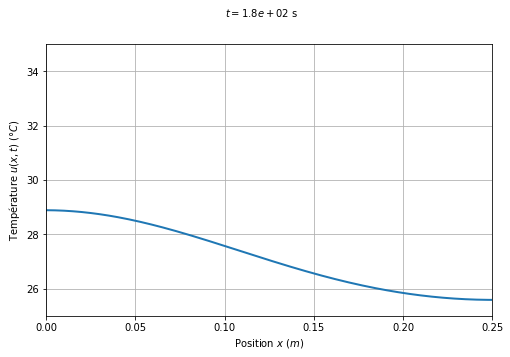

In [52]:
sigma = 0.3
x0 = 0.

U0 = 25+10*np.exp(-25*(X_s-x0)**2/sigma**2)

solvaro(U0, True)

Encore une autre, avec une « cuve » de température
$$
u(x,0) = 25 + 30\left(\exp\left(-\frac{x^2}{\sigma^2}\right)+\exp\left(-\frac{(x-L)^2}{\sigma^2}\right)\right)
$$

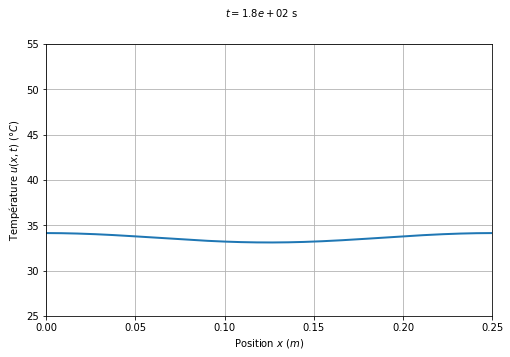

In [54]:
sigma = 0.2
x0 = 0.
x1 = L
U0 = 25+30*(np.exp(-25*(X_s-x0)**2/sigma**2)+np.exp(-25*(X_s-x1)**2/sigma**2))

solvaro(U0, True)